In [98]:
# Librerias basicas 
import numpy as np 
import pandas as pd 
import os

# Visualizacióon
import matplotlib.pyplot as plt
import seaborn as sns 
from plotly import express as px

# Funciones auxiliares sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, KFold, cross_val_predict, GridSearchCV
from sklearn.metrics import cohen_kappa_score, make_scorer, accuracy_score, balanced_accuracy_score, confusion_matrix, roc_curve, auc, accuracy_score, mean_absolute_error, r2_score, classification_report # Metricas
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance

# Preprocessing
from sklearn.preprocessing import StandardScaler

# Guardar modelos
import pickle

# Models
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor

# WoE
from category_encoders import *

# Preprocesamiento de datos
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler


# Plot de matriz de confusion normalizada en actuals
from utils import plot_confusion_matrix, get_artifact_filename

# Optimizacion de hiperparametros
import optuna
from optuna.artifacts import FileSystemArtifactStore, upload_artifact

#Guardado de objetos en archivos joblib
from joblib import load, dump

import warnings
warnings.filterwarnings("ignore")

In [2]:
#Subimos dos niveles para quedar en la carpeta que contiene input y lab2-mcd-austral
BASE_DIR = './'

#Salida de modelos entrenados
PATH_TO_MODELS = os.path.join(BASE_DIR, "work/models")

#Artefactos a subir a optuna
PATH_TO_TEMP_FILES = os.path.join(BASE_DIR, "work/optuna_temp_artifacts")

#Artefactos que optuna gestiona
PATH_TO_OPTUNA_ARTIFACTS = os.path.join(BASE_DIR, "work/optuna_artifacts")

# Clasificación

Para clasificar decidimos utilizar el dataset de Titanic para predecir si una persona sobrevive o no.

Diccionario de datos

- Survived -> Survival - target (0 = No, 1 = Si)
- Pclass -> Ticket Class (1 = 1st, 2 = 2nd, 3 = 3rd)
- Age -> Age in years
- Sex -> Sex (male, female)
- SibSp -> of siblings / spouses aboard the Titanic
- Parch -> of parents / children aboard the Titanic
- Ticket -> ticket number
- Fare -> Passenger Fare (Tarifa)
- Cabin -> cabin Number
- Embarked -> Port of Embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)

Leemos el dataset

In [3]:
df = pd.read_csv('./csv/titanic_train.csv')

### Análisis exploratorio de datos

Filas y Columnas

In [4]:
df.shape

(891, 12)

Datos

In [5]:
df.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S


Tipos de variables

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Cantidad de nulos

In [7]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Cantidad de nulos expresados en porcentajes

In [8]:
df.isnull().sum().sort_values(ascending=False)/ len(df)

Cabin          0.771044
Age            0.198653
Embarked       0.002245
PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
dtype: float64

Medidas de tendencia central y de dispersión

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


Matriz de correlación

<Axes: >

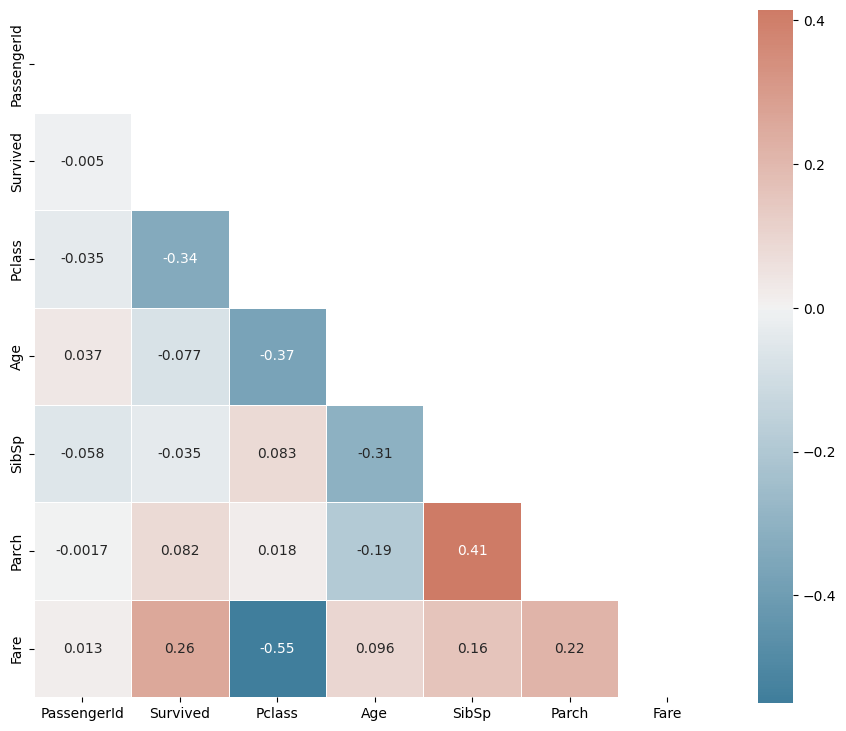

In [10]:
# Identificar columnas numéricas
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Eliminamos variables que no nos interesan.
#df_copy.drop(['index','education.num','education','workclass','marital.status','occupation','relationship','race','sex','native.country','income'], axis=1, inplace=True)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(df[numeric_cols].corr(), dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(df[numeric_cols].corr(), mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, annot=True)

Distribución de la variable target _"Survived"_

C:\Users\fcarreno\AppData\Local\Temp\ipykernel_18344\2659043324.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=income_percentages.index, y=income_percentages.values, palette='viridis')


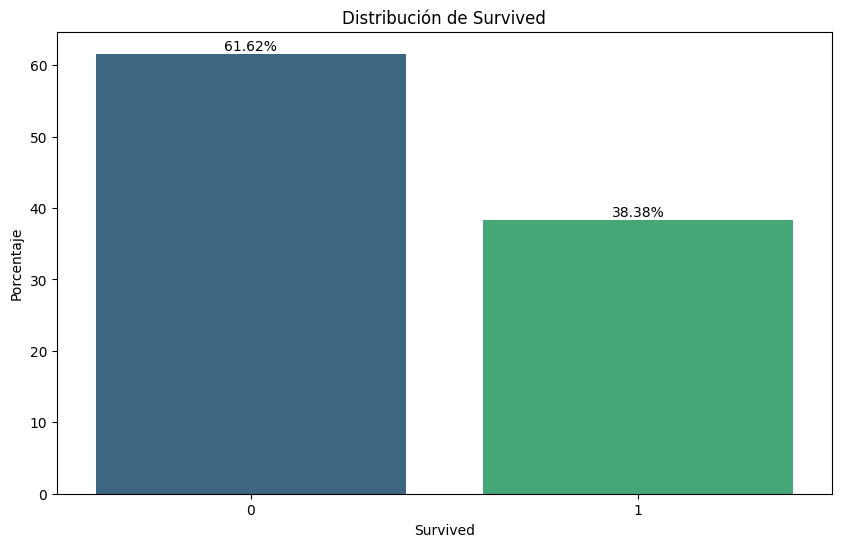

In [11]:
# Calcular los porcentajes
income_counts = df['Survived'].value_counts()
income_percentages = income_counts / income_counts.sum() * 100

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x=income_percentages.index, y=income_percentages.values, palette='viridis')

# Añadir los porcentajes en la parte superior de las barras
for index, value in enumerate(income_percentages.values):
    plt.text(index, value, f'{value:.2f}%', ha='center', va='bottom')

# Personalizar el gráfico
plt.title('Distribución de Survived')
plt.xlabel('Survived')
plt.ylabel('Porcentaje')

plt.show()

In [12]:
df.Survived.value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

### Preprocesamiento y Feature Engineering

Eliminamos variable Cabin por su alto procentaje de NAs 

In [13]:
df = df.drop(columns = ["Cabin"]) # eliminar la columna Cabin porque tienen un bastante valores NA

Creamos variable _"titulo"_

In [14]:
# Dado que el 20% de Age está null, necesito deducir las edades a partir del title.
df['titulo']=df['Name'].map(lambda x:x.split(',')[1].split('.')[0].strip())
df['titulo'].value_counts()

titulo
Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
the Countess      1
Capt              1
Ms                1
Sir               1
Lady              1
Mme               1
Don               1
Jonkheer          1
Name: count, dtype: int64

In [15]:
df[df.Age.isnull()].groupby("titulo").size() # agrupo por título los datos null y cuento la cantidad de cada categoría

titulo
Dr          1
Master      4
Miss       36
Mr        119
Mrs        17
dtype: int64

Se completarán los valores de la _edad_ en base a la media de la edad por el titulo

In [16]:
# Se completarán los valores de la edad en base a la media de la edad por el titulo.
# tituloEdad tendrá la columna titulo+edad, que es la media de cada título.
tituloEdad = df[df.Age.isnull() == False].groupby("titulo").agg({"Age": "mean"}).reset_index()

In [17]:
#hacer un leftjoin entre data y tituloEdad sobre la columna título.
df = pd.merge(df, tituloEdad, how="left", on="titulo")
#reemplazo el nombre de la columna Age_x por Age.
df = df.rename (columns = {"Age_x" : "Age"}) #El "_x" se usa para distinguir la columna de la base de la izq.

In [18]:
#para las filas donde la edad es null y el título no es Mr, que tomen la media calculada anteriormente (Age_y) como Age,
#de lo contrario, que tome el dato como viene.
df["Age"] = np.where((df.Age.isnull()) & (df.titulo != "Mr"), df.Age_y, df.Age)
df = df.drop(columns = ["Age_y"])

Para los Mr, se calculará la _edad_ como la mediana de edad por Clase y Puerto de embarque

In [19]:
medianAge = df[df.Age.isnull() == False].groupby(["Pclass", "Embarked"]).agg( {"Age": "median"}).reset_index().rename(columns = {"Age": "medianAge"})
df = pd.merge(df, medianAge, how="left", on = ["Pclass", "Embarked"])
df["Age"] = np.where(df.Age.isnull(), df.medianAge, df.Age)
df = df.drop(columns = ["medianAge"])

Imputamos NAs de _Embarked_ por la moda

In [20]:
#Reemplazo los nulls en Embarked por la moda de esta columna
df["Embarked"] = np.where(df.Embarked.isnull(), df.Embarked.mode().values[0], df.Embarked)

En base a la edad creamos una variable que será el Ratio entre la edad y la mediana de edad abierta por título

In [21]:
medianAge = df.groupby("titulo").agg( {"Age": "median"}).reset_index().rename(columns = {"Age": "medianAge"})
df = pd.merge(df, medianAge, how="left", on = "titulo")
df["ageRatioTitle"] = df.Age / df.medianAge
df.drop(columns=["medianAge"], inplace = True)

Comenzamos a trabajar sobre la imputación de variables categóricas. Comenzaremos con la variable titulo. Para esta variable trabajaremos con el método WoE (Weigth of Evidence)

Aplicamos WoE a _SibSp_

In [22]:
# Transformar la columna SibSp con la variable target Survived y reemplazo la columna SibSp por el cálculo woe_sibSp
WOE_encoder = WOEEncoder()
sibSp = WOE_encoder.fit_transform(df["SibSp"].astype(str), df.Survived)
df = df.join(sibSp.rename(columns = {"SibSp":"woe_sibSp"}))

Creamos variable _withFamily_

In [23]:
#creamos la variable withfamily considerando SibSp y Parch.
df["withFamily"] = np.where((df.SibSp+df.Parch) >= 0, 1, 0)

Eliminamos columna _Sibsp_

In [24]:
#eliminamos la columna SibSp
df.drop(columns=["SibSp"], inplace=True)

Aplicamos WoE a _Parch_

In [25]:
#hacer el mismo proceso con Parch
WOE_encoder = WOEEncoder()
parch = WOE_encoder.fit_transform(df["Parch"].astype(str), df.Survived)
df = df.join(parch.rename(columns = {"Parch":"woe_parch"}))
df.drop(columns=["Parch"], inplace=True)

Aplicamos WoE a _Titulo_

In [26]:
#lo mismo con la variable Título
WOE_encoder = WOEEncoder()
titulo = WOE_encoder.fit_transform(df["titulo"].astype(str), df.Survived)
df = df.join(titulo.rename(columns = {"titulo":"woe_title"}))
df.drop(columns=["titulo"], inplace=True)

Creamos varaible _ageRatioClass_

In [27]:
medianAge = df.groupby("Pclass").agg( {"Age": "median"}).reset_index().rename(columns = {"Age": "medianAge"})
df = pd.merge(df, medianAge, how="left", on = "Pclass")
df["ageRatioClass"] = df.Age / df.medianAge
df.drop(columns=["medianAge"], inplace = True)

Creamos variable _fareRatioClass_

In [28]:
df = pd.merge(df,
         df.groupby("Pclass").agg({"Fare": "median"}).reset_index().rename(columns={"Fare": "medianFare"}),
         how = "inner", on="Pclass")
df["fareRatioClass"] = df.Fare / df.Age
df.drop(columns=["medianFare"], inplace=True)

Aplicamos OneHotEncoder a _Sex_

In [29]:
df.join(pd.get_dummies(df[["Sex"]]))
df.drop(columns=["Sex"], inplace=True)

Aplicamos OneHotEncoder a _Embarked_

In [30]:
df.join(pd.get_dummies(df[["Embarked"]]))
df.drop(columns=["Embarked"], inplace=True)

Aplicamos OneHotEncodera _Pclass_

In [31]:
df.join(pd.get_dummies(df[["Pclass"]].astype(str)))
df.drop(columns=["Pclass"], inplace=True)

Eliminamos columnas _Name_ y _Ticket_

In [32]:
df.drop(columns=["Name", "Ticket"], inplace=True)

Guardamos el dataset preprocesado

In [33]:
df.to_csv('./csv/titanicPreprocesada.csv', index=False, sep=';')

Levantamos el dataset preprocesado

In [34]:
df = pd.read_csv('./csv/titanicPreprocesada.csv', sep=';')

Normalizar variables numéricas

In [35]:
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
columns_not_scaler = ['PassengerId','Survived','withFamily']
numeric_features = [col for col in numeric_features if col not in columns_not_scaler]

In [36]:
# Estandarizar las columnas numéricas
scaler = StandardScaler()
df[numeric_features] = scaler.fit_transform(df[numeric_features])

### Train Test

In [37]:
SEED = 12345
TEST_SIZE = 0.2

In [38]:
X = df.drop(columns = ["Survived"])
y = df.Survived

# División en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=SEED)

In [39]:
# Combinar X_train y y_train en un solo DataFrame
train = pd.concat([X_train, y_train], axis=1)

# Combinar X_test y y_test en un solo DataFrame
test = pd.concat([X_test, y_test], axis=1)

In [40]:
conjuntos = {"X_train": X_train, "X_test": X_test, "y_train": y_train, "y_test": y_test}
for key, value in conjuntos.items():
    print(f"{key}: {len(value)} filas")

X_train: 712 filas
X_test: 179 filas
y_train: 712 filas
y_test: 179 filas


### Modelos

### Support Vector Machine

In [41]:
#Genero una metrica para que lightGBM haga la evaluación y pueda hacer early_stopping en el cross validation
def svc_custom_metric_accuracy(dy_pred, dy_true):
    metric_name = 'accuracy'
    value = accuracy_score(dy_true.get_label(), dy_pred.argmax(axis=1))
    is_higher_better = True
    return(metric_name, value, is_higher_better)

#Funcion objetivo a optimizar. En este caso vamos a hacer 5fold cv sobre el conjunto de train. 
# El score de CV es el objetivo a optimizar. Ademas vamos a usar los 5 modelos del CV para estimar el conjunto de test,
# registraremos en optuna las predicciones, matriz de confusion y el score en test.
# CV Score -> Se usa para determinar el rendimiento de los hiperparametros con precision 
# Test Score -> Nos permite testear que esta todo OK, no use (ni debo usar) esos datos para nada en el entrenamiento 
# o la optimizacion de hiperparametros

def cv_es_svc_objective(trial,kernel):

    svc_params = {  'C': trial.suggest_loguniform('C', 0.2, 10),
                    'kernel': kernel,
                    'class_weight': trial.suggest_categorical('class_weight', ['balanced', None]),
                    'probability': True
                    } 
    if kernel == 'linear':
       svc_params['C'] = trial.suggest_loguniform('C', 0.2, 1)
    if kernel == 'rbf':
        svc_params['gamma'] = trial.suggest_loguniform('gamma', 1e-5, 10)
    elif kernel == 'poly':
        svc_params['C'] = trial.suggest_loguniform('C', 0.2, 1)
        svc_params['gamma'] = "scale"
        svc_params['degree'] = trial.suggest_int('degree', 2, 5)
    elif kernel == 'sigmoid':
        svc_params['gamma'] = trial.suggest_loguniform('gamma', 1e-5, 1e1)
        svc_params['degree'] = trial.suggest_int('degree', 2, 5)
    #Voy a generar estimaciones de los 5 modelos del CV sobre los datos test y los acumulo en la matriz scores_ensemble
    scores_ensemble = np.zeros((len(y_test),len(y_train.unique())))

    #Score del 5 fold CV inicializado en 0
    score_folds = 0

    #Numero de splits del CV
    n_splits = 5

    #Objeto para hacer el split estratificado de CV
    skf = StratifiedKFold(n_splits=n_splits)

    for i, (if_index, oof_index) in enumerate(skf.split(X_train, y_train)):
        
        # Dataset in fold (donde entreno)
        X_if, y_if = X_train.iloc[if_index], y_train.iloc[if_index]
        
        # Dataset Out of fold (donde mido la performance del CV)
        X_oof, y_oof = X_train.iloc[oof_index], y_train.iloc[oof_index]

        # Crear el modelo RandomForestClassifier con los parámetros sugeridos
        svc_model = SVC(**svc_params, random_state=42)
        
        # Entrenar el modelo
        svc_model.fit(X_if, y_if)
        
        # Acumular los scores (probabilidades) de cada clase para cada uno de los modelos que determino en los folds
        scores_ensemble += svc_model.predict_proba(X_test)
        
        # Score del fold (registros de dataset train que en este fold quedan out of fold)
        score_folds += accuracy_score(y_oof, svc_model.predict(X_oof)) / n_splits


    #Guardo prediccion del trial sobre el conjunto de test
    # Genero nombre de archivo
    predicted_filename = os.path.join(PATH_TO_TEMP_FILES,f'test_{trial.study.study_name}_{trial.number}.joblib')
    # Copia del dataset para guardar la prediccion
    predicted_df = test.copy()
    # Genero columna pred con predicciones sumadas de los 5 folds
    predicted_df['pred'] = [scores_ensemble[p,:] for p in range(scores_ensemble.shape[0])]
    # Grabo dataframe en temp_artifacts
    dump(predicted_df, predicted_filename)
    # Indico a optuna que asocie el archivo generado al trial
    upload_artifact(trial, predicted_filename, artifact_store)    

    #Grabo natriz de confusion
    #Nombre de archivo
    cm_filename = os.path.join(PATH_TO_TEMP_FILES,f'cm_{trial.study.study_name}_{trial.number}.jpg')
    #Grabo archivo
    plot_confusion_matrix(y_test,scores_ensemble.argmax(axis=1)).write_image(cm_filename)
    #Asocio al trial
    upload_artifact(trial, cm_filename, artifact_store)

    #Determino score en conjunto de test y asocio como metrica adicional en optuna
    test_score = accuracy_score(y_test, scores_ensemble.argmax(axis=1))
    trial.set_user_attr("test_score", test_score)

    #Devuelvo score del 5fold cv a optuna para que optimice en base a eso
    return(score_folds)
artifact_store = FileSystemArtifactStore(base_path=PATH_TO_OPTUNA_ARTIFACTS)

C:\Users\fcarreno\AppData\Local\Temp\ipykernel_18344\551731212.py:92: ExperimentalWarning: FileSystemArtifactStore is experimental (supported from v3.3.0). The interface can change in the future.
  artifact_store = FileSystemArtifactStore(base_path=PATH_TO_OPTUNA_ARTIFACTS)


In [ ]:
#Inicio el store de artefactos (archivos) de optuna

def objective_wrapper(trial):
    kernel = trial.suggest_categorical('kernel', ['rbf'])
    return cv_es_svc_objective(trial, kernel)
#Genero estudio
study = optuna.create_study(direction='maximize',
                            storage="sqlite:///prueba.sqlite3",  # Specify the storage URL here.
                            study_name="SupportVectorClassifier RBF",
                            load_if_exists = True)
#Corro la optimizacion
study.optimize(objective_wrapper, n_trials=100)

In [ ]:
def objective_wrapper(trial):
    kernel = trial.suggest_categorical('kernel', ['sigmoid'])
    return cv_es_svc_objective(trial, kernel)
study = optuna.create_study(direction='maximize',
                            storage="sqlite:///prueba.sqlite3",  # Specify the storage URL here.
                            study_name="SupportVectorClassifier Sigmoid",
                            load_if_exists = True)
#Corro la optimizacion
study.optimize(objective_wrapper, n_trials=100)

In [ ]:
def objective_wrapper(trial):
    kernel = trial.suggest_categorical('kernel', ['linear'])
    return cv_es_svc_objective(trial, kernel)
study = optuna.create_study(direction='maximize',
                            storage="sqlite:///prueba.sqlite3",  # Specify the storage URL here.
                            study_name="SupportVectorClassifier Linear",
                            load_if_exists = True)
#Corro la optimizacion
study.optimize(objective_wrapper, n_trials=100)

In [ ]:
def objective_wrapper(trial):
    kernel = trial.suggest_categorical('kernel', ['poly'])
    return cv_es_svc_objective(trial, kernel)
study = optuna.create_study(direction='maximize',
                            storage="sqlite:///prueba.sqlite3",  # Specify the storage URL here.
                            study_name="SupportVectorClassifier Poly",
                            load_if_exists = True)
#Corro la optimizacion
study.optimize(objective_wrapper, n_trials=100)

### Random Forest

In [61]:
#Genero una metrica para que lightGBM haga la evaluación y pueda hacer early_stopping en el cross validation
def rfc_custom_metric_accuracy(dy_pred, dy_true):
    metric_name = 'accuracy'
    value = accuracy_score(dy_true.get_label(), dy_pred.argmax(axis=1))
    is_higher_better = True
    return(metric_name, value, is_higher_better)

#Funcion objetivo a optimizar. En este caso vamos a hacer 5fold cv sobre el conjunto de train. 
# El score de CV es el objetivo a optimizar. Ademas vamos a usar los 5 modelos del CV para estimar el conjunto de test,
# registraremos en optuna las predicciones, matriz de confusion y el score en test.
# CV Score -> Se usa para determinar el rendimiento de los hiperparametros con precision 
# Test Score -> Nos permite testear que esta todo OK, no use (ni debo usar) esos datos para nada en el entrenamiento 
# o la optimizacion de hiperparametros

def cv_es_rfc_objective(trial):

    #Parametros para LightGBM
    rfc_params = {      
                        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=100),
                        'max_depth': trial.suggest_int('max_depth', 3, 15),
                        #'max_depth': trial.suggest_int('max_depth', 3, 4)
                        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
                        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
                        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
                        'bootstrap': trial.suggest_categorical('bootstrap', [True, False])
                        } 

    #Voy a generar estimaciones de los 5 modelos del CV sobre los datos test y los acumulo en la matriz scores_ensemble
    scores_ensemble = np.zeros((len(y_test),len(y_train.unique())))

    #Score del 5 fold CV inicializado en 0
    score_folds = 0

    #Numero de splits del CV
    n_splits = 5

    #Objeto para hacer el split estratificado de CV
    skf = StratifiedKFold(n_splits=n_splits)

    for i, (if_index, oof_index) in enumerate(skf.split(X_train, y_train)):
        
        # Dataset in fold (donde entreno)
        X_if, y_if = X_train.iloc[if_index], y_train.iloc[if_index]
        
        # Dataset Out of fold (donde mido la performance del CV)
        X_oof, y_oof = X_train.iloc[oof_index], y_train.iloc[oof_index]

        # Crear el modelo RandomForestClassifier con los parámetros sugeridos
        rfc_model = RandomForestClassifier(**rfc_params, random_state=42)
        
        # Entrenar el modelo
        rfc_model.fit(X_if, y_if)
        
        # Acumular los scores (probabilidades) de cada clase para cada uno de los modelos que determino en los folds
        scores_ensemble += rfc_model.predict_proba(X_test)
        
        # Score del fold (registros de dataset train que en este fold quedan out of fold)
        score_folds += accuracy_score(y_oof, rfc_model.predict(X_oof)) / n_splits


    #Guardo prediccion del trial sobre el conjunto de test
    # Genero nombre de archivo
    predicted_filename = os.path.join(PATH_TO_TEMP_FILES,f'test_{trial.study.study_name}_{trial.number}.joblib')
    # Copia del dataset para guardar la prediccion
    predicted_df = test.copy()
    # Genero columna pred con predicciones sumadas de los 5 folds
    predicted_df['pred'] = [scores_ensemble[p,:] for p in range(scores_ensemble.shape[0])]
    # Grabo dataframe en temp_artifacts
    dump(predicted_df, predicted_filename)
    # Indico a optuna que asocie el archivo generado al trial
    upload_artifact(trial, predicted_filename, artifact_store)    

    #Grabo natriz de confusion
    #Nombre de archivo
    cm_filename = os.path.join(PATH_TO_TEMP_FILES,f'cm_{trial.study.study_name}_{trial.number}.jpg')
    #Grabo archivo
    plot_confusion_matrix(y_test,scores_ensemble.argmax(axis=1)).write_image(cm_filename)
    #Asocio al trial
    upload_artifact(trial, cm_filename, artifact_store)

    #Determino score en conjunto de test y asocio como metrica adicional en optuna
    test_score = accuracy_score(y_test, scores_ensemble.argmax(axis=1))
    trial.set_user_attr("test_score", test_score)

    #Devuelvo score del 5fold cv a optuna para que optimice en base a eso
    return(score_folds)

In [ ]:
#Inicio el store de artefactos (archivos) de optuna
artifact_store = FileSystemArtifactStore(base_path=PATH_TO_OPTUNA_ARTIFACTS)

#Genero estudio
study = optuna.create_study(direction='maximize',
                            storage="sqlite:///prueba.sqlite3",  # Specify the storage URL here.
                            study_name="RandomForestClasiffier",
                            load_if_exists = True)
#Corro la optimizacion
study.optimize(cv_es_rfc_objective, n_trials=100)

### Gradient Boosting

In [64]:
#Genero una metrica para que lightGBM haga la evaluación y pueda hacer early_stopping en el cross validation
def gbc_custom_metric_accuracy(dy_pred, dy_true):
    metric_name = 'accuracy'
    value = accuracy_score(dy_true.get_label(), dy_pred.argmax(axis=1))
    is_higher_better = True
    return(metric_name, value, is_higher_better)

#Funcion objetivo a optimizar. En este caso vamos a hacer 5fold cv sobre el conjunto de train. 
# El score de CV es el objetivo a optimizar. Ademas vamos a usar los 5 modelos del CV para estimar el conjunto de test,
# registraremos en optuna las predicciones, matriz de confusion y el score en test.
# CV Score -> Se usa para determinar el rendimiento de los hiperparametros con precision 
# Test Score -> Nos permite testear que esta todo OK, no use (ni debo usar) esos datos para nada en el entrenamiento 
# o la optimizacion de hiperparametros

def cv_es_gbc_objective(trial):

    #Parametros para LightGBM
    gbc_params = {      
                        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
                        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1.0),
                        'max_depth': trial.suggest_int('max_depth', 3, 10),
                        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
                        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
                        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0)
                        #'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
                        #'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None, 'auto']),
                        #'loss': trial.suggest_categorical('loss', ['deviance', 'exponential']),
                        } 

    #Voy a generar estimaciones de los 5 modelos del CV sobre los datos test y los acumulo en la matriz scores_ensemble
    scores_ensemble = np.zeros((len(y_test),len(y_train.unique())))

    #Score del 5 fold CV inicializado en 0
    score_folds = 0

    #Numero de splits del CV
    n_splits = 5

    #Objeto para hacer el split estratificado de CV
    skf = StratifiedKFold(n_splits=n_splits)

    for i, (if_index, oof_index) in enumerate(skf.split(X_train, y_train)):
        
        # Dataset in fold (donde entreno)
        X_if, y_if = X_train.iloc[if_index], y_train.iloc[if_index]
        
        # Dataset Out of fold (donde mido la performance del CV)
        X_oof, y_oof = X_train.iloc[oof_index], y_train.iloc[oof_index]

        # Crear el modelo RandomForestClassifier con los parámetros sugeridos
        gbc_model = GradientBoostingClassifier(**gbc_params, random_state=42)
        
        # Entrenar el modelo
        gbc_model.fit(X_if, y_if)
        
        # Acumular los scores (probabilidades) de cada clase para cada uno de los modelos que determino en los folds
        scores_ensemble += gbc_model.predict_proba(X_test)
        
        # Score del fold (registros de dataset train que en este fold quedan out of fold)
        score_folds += accuracy_score(y_oof, gbc_model.predict(X_oof)) / n_splits


    #Guardo prediccion del trial sobre el conjunto de test
    # Genero nombre de archivo
    predicted_filename = os.path.join(PATH_TO_TEMP_FILES,f'test_{trial.study.study_name}_{trial.number}.joblib')
    # Copia del dataset para guardar la prediccion
    predicted_df = test.copy()
    # Genero columna pred con predicciones sumadas de los 5 folds
    predicted_df['pred'] = [scores_ensemble[p,:] for p in range(scores_ensemble.shape[0])]
    # Grabo dataframe en temp_artifacts
    dump(predicted_df, predicted_filename)
    # Indico a optuna que asocie el archivo generado al trial
    upload_artifact(trial, predicted_filename, artifact_store)    

    #Grabo natriz de confusion
    #Nombre de archivo
    cm_filename = os.path.join(PATH_TO_TEMP_FILES,f'cm_{trial.study.study_name}_{trial.number}.jpg')
    #Grabo archivo
    plot_confusion_matrix(y_test,scores_ensemble.argmax(axis=1)).write_image(cm_filename)
    #Asocio al trial
    upload_artifact(trial, cm_filename, artifact_store)

    #Determino score en conjunto de test y asocio como metrica adicional en optuna
    test_score = accuracy_score(y_test, scores_ensemble.argmax(axis=1))
    trial.set_user_attr("test_score", test_score)

    #Devuelvo score del 5fold cv a optuna para que optimice en base a eso
    return(score_folds)

In [ ]:
#Inicio el store de artefactos (archivos) de optuna
artifact_store = FileSystemArtifactStore(base_path=PATH_TO_OPTUNA_ARTIFACTS)

#Genero estudio
study = optuna.create_study(direction='maximize',
                            storage="sqlite:///prueba.sqlite3",  # Specify the storage URL here.
                            study_name="GradientBoostingClasiffier",
                            load_if_exists = True)
#Corro la optimizacion
study.optimize(cv_es_gbc_objective, n_trials=100)

### Multilayer Perceptron

In [70]:
#Genero una metrica para que lightGBM haga la evaluación y pueda hacer early_stopping en el cross validation
def mlp_custom_metric_accuracy(dy_pred, dy_true):
    metric_name = 'accuracy'
    value = accuracy_score(dy_true.get_label(), dy_pred.argmax(axis=1))
    is_higher_better = True
    return(metric_name, value, is_higher_better)

#Funcion objetivo a optimizar. En este caso vamos a hacer 5fold cv sobre el conjunto de train. 
# El score de CV es el objetivo a optimizar. Ademas vamos a usar los 5 modelos del CV para estimar el conjunto de test,
# registraremos en optuna las predicciones, matriz de confusion y el score en test.
# CV Score -> Se usa para determinar el rendimiento de los hiperparametros con precision 
# Test Score -> Nos permite testear que esta todo OK, no use (ni debo usar) esos datos para nada en el entrenamiento 
# o la optimizacion de hiperparametros

def cv_es_mlp_objective(trial):

    #Parametros para LightGBM
    mlp_params = {      
                        'hidden_layer_sizes': trial.suggest_categorical('hidden_layer_sizes', [
                            (50,), (100,), (50, 50), (100, 50), (100, 100)
                        ]),
                        'activation': trial.suggest_categorical('activation', ['relu', 'tanh', 'logistic']),
                        'solver': trial.suggest_categorical('solver', ['adam', 'sgd']),
                        'alpha': trial.suggest_loguniform('alpha', 1e-5, 1e-1),
                        'learning_rate': trial.suggest_categorical('learning_rate', ['constant', 'adaptive']),
                        'max_iter': trial.suggest_int('max_iter', 100, 500),
                        'early_stopping': trial.suggest_categorical('early_stopping', [True, False])
                        } 

    #Voy a generar estimaciones de los 5 modelos del CV sobre los datos test y los acumulo en la matriz scores_ensemble
    scores_ensemble = np.zeros((len(y_test),len(y_train.unique())))

    #Score del 5 fold CV inicializado en 0
    score_folds = 0

    #Numero de splits del CV
    n_splits = 5

    #Objeto para hacer el split estratificado de CV
    skf = StratifiedKFold(n_splits=n_splits)

    for i, (if_index, oof_index) in enumerate(skf.split(X_train, y_train)):
        
        # Dataset in fold (donde entreno)
        X_if, y_if = X_train.iloc[if_index], y_train.iloc[if_index]
        
        # Dataset Out of fold (donde mido la performance del CV)
        X_oof, y_oof = X_train.iloc[oof_index], y_train.iloc[oof_index]

        # Crear el modelo RandomForestClassifier con los parámetros sugeridos
        mlp_model = MLPClassifier(**mlp_params, random_state=42)
        
        # Entrenar el modelo
        mlp_model.fit(X_if, y_if)
        
        # Acumular los scores (probabilidades) de cada clase para cada uno de los modelos que determino en los folds
        scores_ensemble += mlp_model.predict_proba(X_test)
        
        # Score del fold (registros de dataset train que en este fold quedan out of fold)
        score_folds += accuracy_score(y_oof, mlp_model.predict(X_oof)) / n_splits


    #Guardo prediccion del trial sobre el conjunto de test
    # Genero nombre de archivo
    predicted_filename = os.path.join(PATH_TO_TEMP_FILES,f'test_{trial.study.study_name}_{trial.number}.joblib')
    # Copia del dataset para guardar la prediccion
    predicted_df = test.copy()
    # Genero columna pred con predicciones sumadas de los 5 folds
    predicted_df['pred'] = [scores_ensemble[p,:] for p in range(scores_ensemble.shape[0])]
    # Grabo dataframe en temp_artifacts
    dump(predicted_df, predicted_filename)
    # Indico a optuna que asocie el archivo generado al trial
    upload_artifact(trial, predicted_filename, artifact_store)    

    #Grabo natriz de confusion
    #Nombre de archivo
    cm_filename = os.path.join(PATH_TO_TEMP_FILES,f'cm_{trial.study.study_name}_{trial.number}.jpg')
    #Grabo archivo
    plot_confusion_matrix(y_test,scores_ensemble.argmax(axis=1)).write_image(cm_filename)
    #Asocio al trial
    upload_artifact(trial, cm_filename, artifact_store)

    #Determino score en conjunto de test y asocio como metrica adicional en optuna
    test_score = accuracy_score(y_test, scores_ensemble.argmax(axis=1))
    trial.set_user_attr("test_score", test_score)

    #Devuelvo score del 5fold cv a optuna para que optimice en base a eso
    return(score_folds)

In [ ]:
#Inicio el store de artefactos (archivos) de optuna
artifact_store = FileSystemArtifactStore(base_path=PATH_TO_OPTUNA_ARTIFACTS)

#Genero estudio
study = optuna.create_study(direction='maximize',
                            storage="sqlite:///prueba.sqlite3",  # Specify the storage URL here.
                            study_name="MultilayerPerceptronClassifier",
                            load_if_exists = True)
#Corro la optimizacion
study.optimize(cv_es_mlp_objective, n_trials=100)

<Axes: title={'center': 'Train y test'}, xlabel='study'>

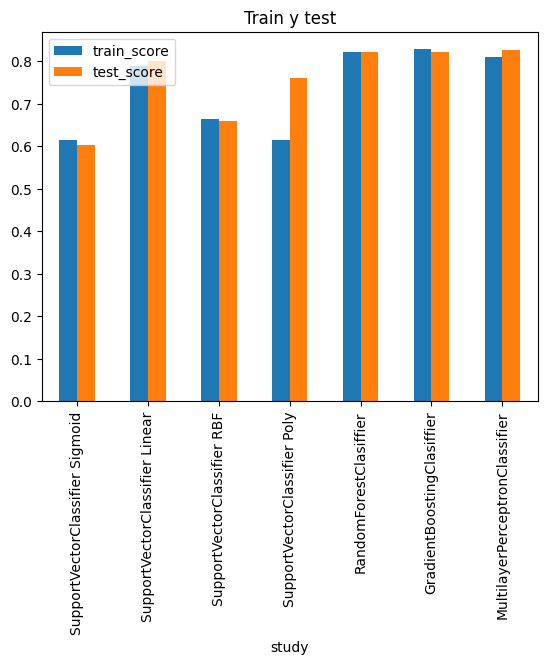

In [97]:

# Obtener el mejor resultado

storage = 'sqlite:///prueba.sqlite3'
studies_names = ['SupportVectorClassifier Sigmoid', 
           'SupportVectorClassifier Linear', 
           'SupportVectorClassifier RBF',
           'SupportVectorClassifier Poly', 
           'RandomForestClasiffier', 
           'GradientBoostingClasiffier',
           'MultilayerPerceptronClassifier']

studies = [optuna.load_study(study_name=study_name, storage=storage) for study_name in studies_names]

df_result = pd.DataFrame()
df_result['study'] = [study.study_name for study in studies]
df_result['best_params'] = [study.best_params for study in studies]
df_result['train_score'] = [study.best_trial.value for study in studies]
df_result['test_score'] = [study.best_trial.user_attrs['test_score'] for study in studies]
df_result.set_index('study', inplace=True   )

df_result[['test_score','train_score']].sort_values('test_score',ascending=False,inplace=True,)

df_result.plot(kind='bar', title='Train y test')

In [106]:
# entrenar todos los modelo para hacer predicciones y construir curva ROC
m_svm_sigmoid = SVC(**df_result["best_params"]["SupportVectorClassifier Sigmoid"],probability=True,random_state=42)
m_svm_sigmoid.fit(X_train, y_train)

m_svm_linear = SVC(**df_result["best_params"]["SupportVectorClassifier Linear"],probability=True,random_state=42)
m_svm_linear.fit(X_train, y_train)

m_svm_rbf = SVC(**df_result["best_params"]["SupportVectorClassifier RBF"],probability=True,random_state=42)
m_svm_rbf.fit(X_train, y_train)

m_svm_poly = SVC(**df_result["best_params"]["SupportVectorClassifier Poly"],probability=True,random_state=42)
m_svm_poly.fit(X_train, y_train)

m_rf = RandomForestClassifier(**df_result["best_params"]["RandomForestClasiffier"],random_state=42)
m_rf.fit(X_train, y_train)

m_gb = GradientBoostingClassifier(**df_result["best_params"]["GradientBoostingClasiffier"],random_state=42)
m_gb.fit(X_train, y_train)

m_mlp = MLPClassifier(**df_result["best_params"]["MultilayerPerceptronClassifier"],random_state=42)
m_mlp.fit(X_train, y_train)


MLPClassifier(alpha=3.711467050003129e-05, hidden_layer_sizes=[50],
              max_iter=469, random_state=42)

In [140]:
# hacer las predicciones
preds = pd.DataFrame()
preds["m_svm_sigmoid"] = m_svm_sigmoid.predict_proba(X_test)[:,1]
preds["m_svm_linear"] = m_svm_linear.predict_proba(X_test)[:,1]
preds["m_svm_rbf"] = m_svm_rbf.predict_proba(X_test)[:,1]
preds["m_svm_poly"] = m_svm_poly.predict_proba(X_test)[:,1]
preds["m_rf"] = m_rf.predict_proba(X_test)[:,1]
preds["m_gb"] = m_gb.predict_proba(X_test)[:,1]
preds["m_mlp"] = m_mlp.predict_proba(X_test)[:,1]

In [141]:
# Calcular la curva ROC y el AUC
fpr_svm_sigmoid, tprsvm_sigmoid, _ = roc_curve(y_test, preds["m_svm_sigmoid"])
roc_auc_svm_sigmoid = auc(fpr_svm_sigmoid, tprsvm_sigmoid)

fpr_svm_linear, tpr_svm_linear, _ = roc_curve(y_test, preds["m_svm_linear"])
roc_auc_svm_linear = auc(fpr_svm_linear, tpr_svm_linear)

fpr_svm_rbf, tpr_svm_rbf, _ = roc_curve(y_test, preds["m_svm_rbf"])
roc_auc_svm_rbf = auc(fpr_svm_rbf, tpr_svm_rbf)

fpr_svm_poly, tpr_svm_poly, _ = roc_curve(y_test, preds["m_svm_poly"])
roc_auc_svm_poly = auc(fpr_svm_poly, tpr_svm_poly)

fpr_rf, tpr_rf, _ = roc_curve(y_test, preds["m_rf"])
roc_auc_rf = auc(fpr_rf, tpr_rf)

fpr_gb, tpr_gb, _ = roc_curve(y_test, preds["m_gb"])
roc_auc_gb = auc(fpr_gb, tpr_gb)

fpr_mlp, tpr_mlp, _ = roc_curve(y_test, preds["m_mlp"])
roc_auc_mlp = auc(fpr_mlp, tpr_mlp)

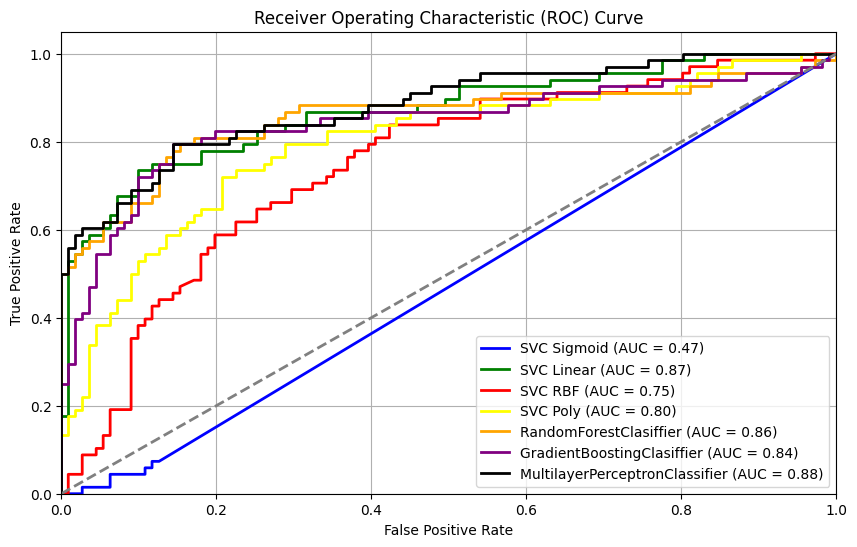

In [142]:
plt.figure(figsize=(10, 6))


plt.plot(fpr_svm_sigmoid, tprsvm_sigmoid, color='blue', lw=2, label=f'SVC Sigmoid (AUC = {roc_auc_svm_sigmoid:.2f})')
plt.plot(fpr_svm_linear, tpr_svm_linear, color='green', lw=2, label=f'SVC Linear (AUC = {roc_auc_svm_linear:.2f})')
plt.plot(fpr_svm_rbf, tpr_svm_rbf, color='red', lw=2, label=f'SVC RBF (AUC = {roc_auc_svm_rbf:.2f})')
plt.plot(fpr_svm_poly, tpr_svm_poly, color='yellow', lw=2, label=f'SVC Poly (AUC = {roc_auc_svm_poly:.2f})')
plt.plot(fpr_rf, tpr_rf, color='orange', lw=2, label=f'RandomForestClasiffier (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr_gb, tpr_gb, color='purple', lw=2, label=f'GradientBoostingClasiffier (AUC = {roc_auc_gb:.2f})')
plt.plot(fpr_mlp, tpr_mlp, color='black', lw=2, label=f'MultilayerPerceptronClassifier (AUC = {roc_auc_mlp:.2f})')

# Graficar la línea de referencia
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')

# Configurar detalles del gráfico
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)

# Mostrar el gráfico
plt.show()

### Matríz de confución

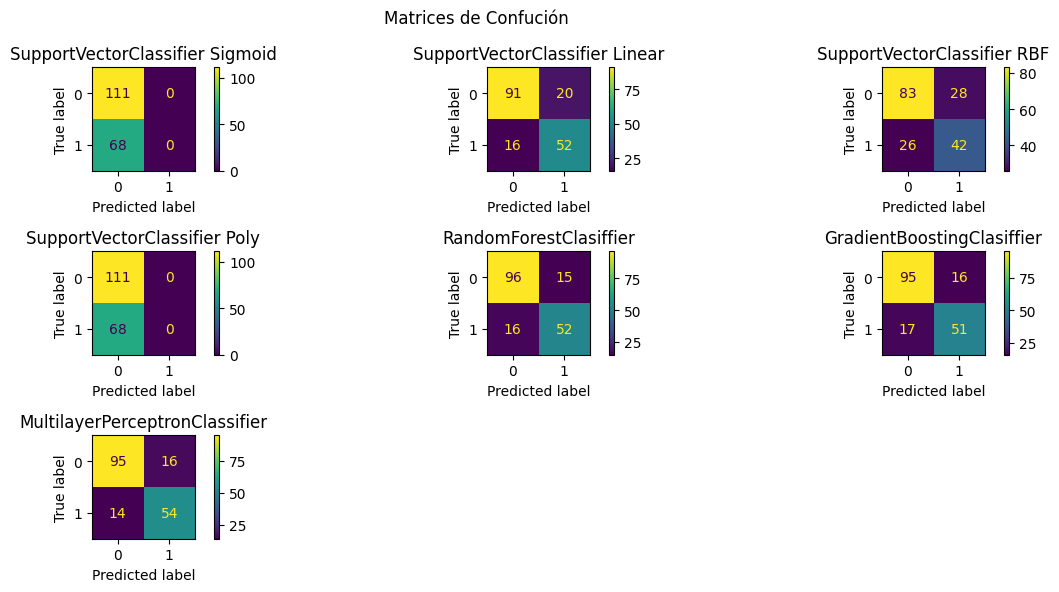

In [147]:
fig, ax = plt.subplots(3, 3, figsize=(12, 6))

cm_svm_sigmoid= metrics.confusion_matrix(y_test, m_svm_sigmoid.predict(X_test))
cm_svm_linear= metrics.confusion_matrix(y_test, m_svm_linear.predict(X_test))
cm_svm_rbf= metrics.confusion_matrix(y_test, m_svm_rbf.predict(X_test))
cm_svm_poly= metrics.confusion_matrix(y_test, m_svm_poly.predict(X_test))
cm_rf= metrics.confusion_matrix(y_test, m_rf.predict(X_test))
cm_gb= metrics.confusion_matrix(y_test, m_gb.predict(X_test))
cm_mlp= metrics.confusion_matrix(y_test, m_mlp.predict(X_test))

metrics.ConfusionMatrixDisplay(confusion_matrix = cm_svm_sigmoid, display_labels = [0, 1]).plot(ax=ax[0,0])
metrics.ConfusionMatrixDisplay(confusion_matrix = cm_svm_linear, display_labels = [0, 1]).plot(ax=ax[0,1])
metrics.ConfusionMatrixDisplay(confusion_matrix = cm_svm_rbf, display_labels = [0, 1]).plot(ax=ax[0,2])
metrics.ConfusionMatrixDisplay(confusion_matrix = cm_svm_poly, display_labels = [0, 1]).plot(ax=ax[1,0])
metrics.ConfusionMatrixDisplay(confusion_matrix = cm_rf, display_labels = [0, 1]).plot(ax=ax[1,1])
metrics.ConfusionMatrixDisplay(confusion_matrix = cm_gb, display_labels = [0, 1]).plot(ax=ax[1,2])
metrics.ConfusionMatrixDisplay(confusion_matrix = cm_mlp, display_labels = [0, 1]).plot(ax=ax[2,0])

ax[0,0].set_title('SupportVectorClassifier Sigmoid')
ax[0,1].set_title('SupportVectorClassifier Linear')
ax[0,2].set_title('SupportVectorClassifier RBF')
ax[1,0].set_title('SupportVectorClassifier Poly')
ax[1,1].set_title('RandomForestClasiffier')
ax[1,2].set_title('GradientBoostingClasiffier')
ax[2,0].set_title('MultilayerPerceptronClassifier')


fig.delaxes(ax[2, 1])
fig.delaxes(ax[2, 2])

plt.suptitle("Matrices de Confución")
plt.tight_layout()

plt.show()

### Métricas

##### Métricas del SVM Sigmoid

In [152]:
print(classification_report(y_test,m_svm_sigmoid.predict(X_test)))

              precision    recall  f1-score   support

           0       0.62      1.00      0.77       111
           1       0.00      0.00      0.00        68

    accuracy                           0.62       179
   macro avg       0.31      0.50      0.38       179
weighted avg       0.38      0.62      0.47       179



##### Métricas del SVM Lineal

In [153]:
print(classification_report(y_test,m_svm_linear.predict(X_test)))

              precision    recall  f1-score   support

           0       0.85      0.82      0.83       111
           1       0.72      0.76      0.74        68

    accuracy                           0.80       179
   macro avg       0.79      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179



##### Métricas del SVM RBF

In [154]:
print(classification_report(y_test,m_svm_rbf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.76      0.75      0.75       111
           1       0.60      0.62      0.61        68

    accuracy                           0.70       179
   macro avg       0.68      0.68      0.68       179
weighted avg       0.70      0.70      0.70       179



##### Métricas del SVM Poly

In [155]:
print(classification_report(y_test,m_svm_poly.predict(X_test)))

              precision    recall  f1-score   support

           0       0.62      1.00      0.77       111
           1       0.00      0.00      0.00        68

    accuracy                           0.62       179
   macro avg       0.31      0.50      0.38       179
weighted avg       0.38      0.62      0.47       179



##### Métricas del Random Forest

In [156]:
print(classification_report(y_test,m_rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86       111
           1       0.78      0.76      0.77        68

    accuracy                           0.83       179
   macro avg       0.82      0.81      0.82       179
weighted avg       0.83      0.83      0.83       179



##### Métricas del Gradient Boosting 

In [157]:
print(classification_report(y_test,m_gb.predict(X_test)))

              precision    recall  f1-score   support

           0       0.85      0.86      0.85       111
           1       0.76      0.75      0.76        68

    accuracy                           0.82       179
   macro avg       0.80      0.80      0.80       179
weighted avg       0.82      0.82      0.82       179



##### Métricas del MLP

In [158]:
print(classification_report(y_test,m_mlp.predict(X_test)))

              precision    recall  f1-score   support

           0       0.87      0.86      0.86       111
           1       0.77      0.79      0.78        68

    accuracy                           0.83       179
   macro avg       0.82      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179



# Regresión

Para regresión decidimos utilizar el dataset "car-prices" donde lo que se busca es predecir el precio de un vehículo.

Diccionario de datos
- Brand: marca del vehículo.
- Body: Tipo de vehículo.
- Mileage: kilometrage.
- EngineV: Tipo de motor.
- Registration: si el vehículo está registrado o no.
- Year: año de lanzamiento.
- Model: modelo del vehículo.
- Price: precio del vehículo (variable target)

Leemos el dataset

In [5]:
df = pd.read_csv('./csv/car-prices.csv')

### Análisis exploratorio de datos

Filas y columnas

In [39]:
df.shape

(4345, 23)

Datos

In [5]:
df.head(1)

,Brand,Price,Body,Mileage,EngineV,Engine Type,Registration,Year,Model
0,BMW,4200.0,sedan,277,2.0,Petrol,yes,1991,320


Tipos de variables

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4345 entries, 0 to 4344
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Brand         4345 non-null   object 
 1   Price         4173 non-null   float64
 2   Body          4345 non-null   object 
 3   Mileage       4345 non-null   int64  
 4   EngineV       4195 non-null   float64
 5   Engine Type   4345 non-null   object 
 6   Registration  4345 non-null   object 
 7   Year          4345 non-null   int64  
 8   Model         4345 non-null   object 
dtypes: float64(2), int64(2), object(5)
memory usage: 305.6+ KB


Cantidad de NAs

In [59]:
df.isna().sum()

Brand             0
Price           172
Body              0
Mileage           0
EngineV         150
Engine Type       0
Registration      0
Year              0
Model             0
dtype: int64

Porcentaje de NAs

In [ ]:
df.isnull().sum().sort_values(ascending=False)/ len(df)

Medidas de tendencia central y de dispersión

In [61]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,4173.0,19418.746935,25584.242620,600.0,6999.0,11500.0,21700.0,300000.00
Mileage,4345.0,161.237284,105.705797,0.0,86.0,155.0,230.0,980.00
EngineV,4195.0,2.790734,5.066437,0.6,1.8,2.2,3.0,99.99
Year,4345.0,2006.550058,6.719097,1969.0,2003.0,2008.0,2012.0,2016.00


Matriz de correlación

<Axes: >

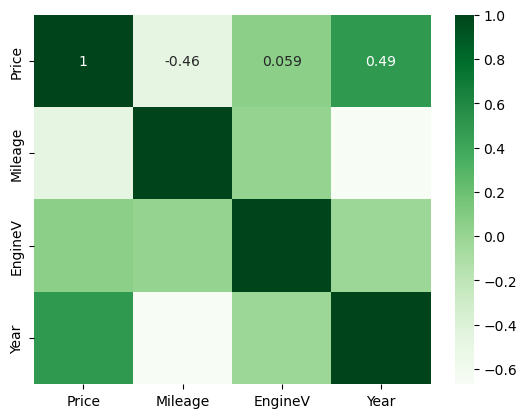

In [62]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
matrix = df[numeric_cols].corr()
sns.heatmap(matrix, cmap="Greens", annot=True)

Price es nuestro target, ¿cómo se distribuye?

c:\Users\Usuario\.conda\envs\ldi2\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Price', ylabel='Count'>

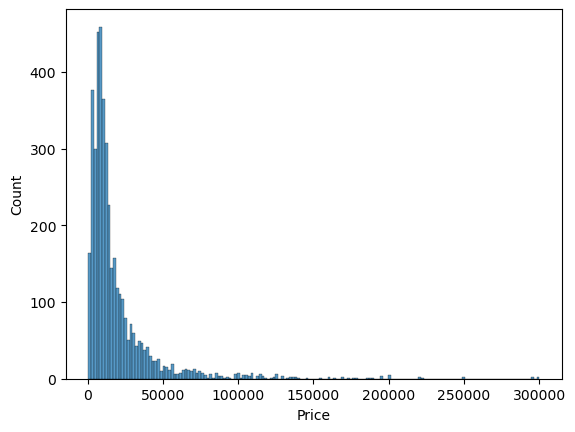

In [63]:
sns.histplot(x= 'Price', data=df)

Boxplot: Variables categóricas vs Price

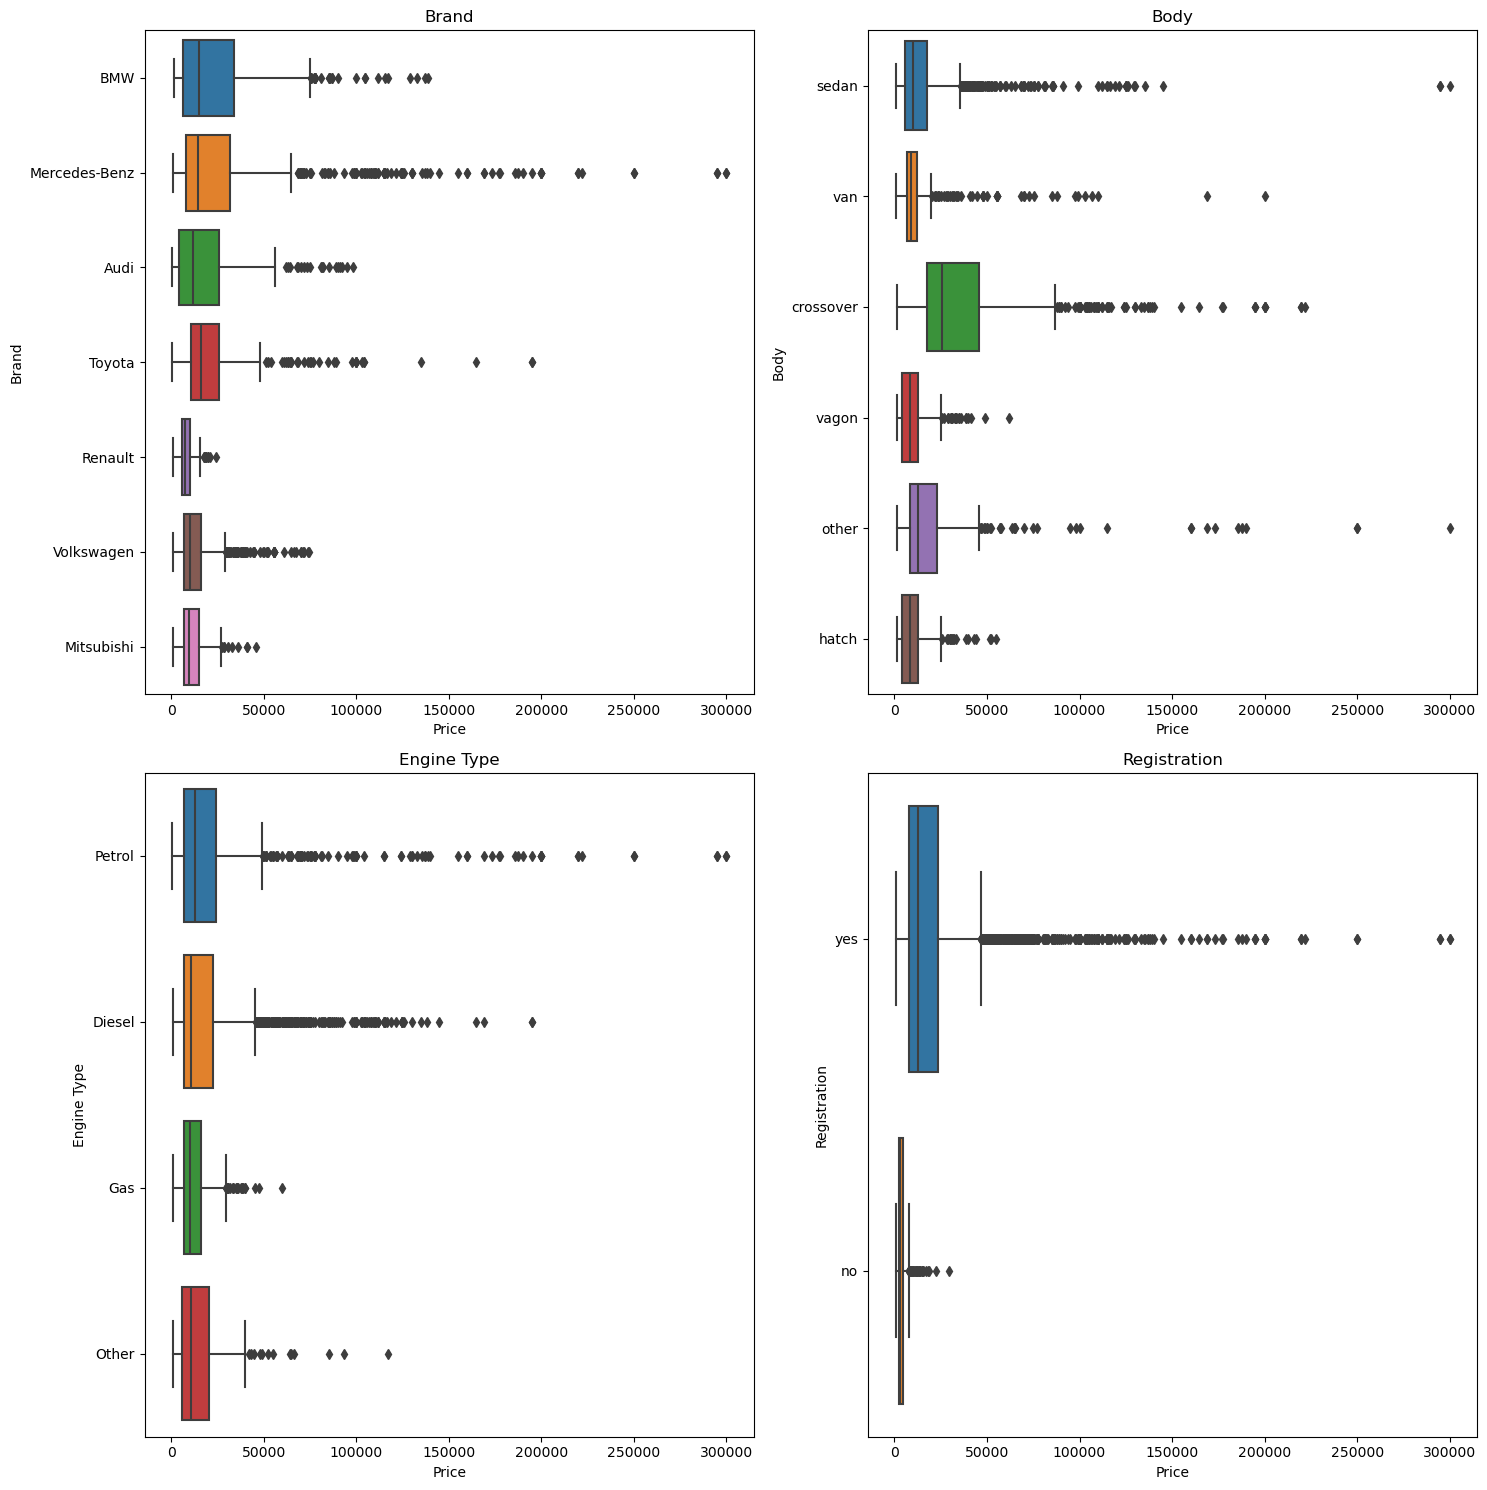

In [71]:
categorical_features = ['Brand', 'Body', 'Engine Type', 'Registration']
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
axes = axes.flatten()
for i, col in enumerate(categorical_features):
    sns.boxplot(data=df,
                x="Price", y=col,
                ax=axes[i])
    axes[i].set_title(col)
plt.tight_layout()
plt.show()

Variables continuas vs Price

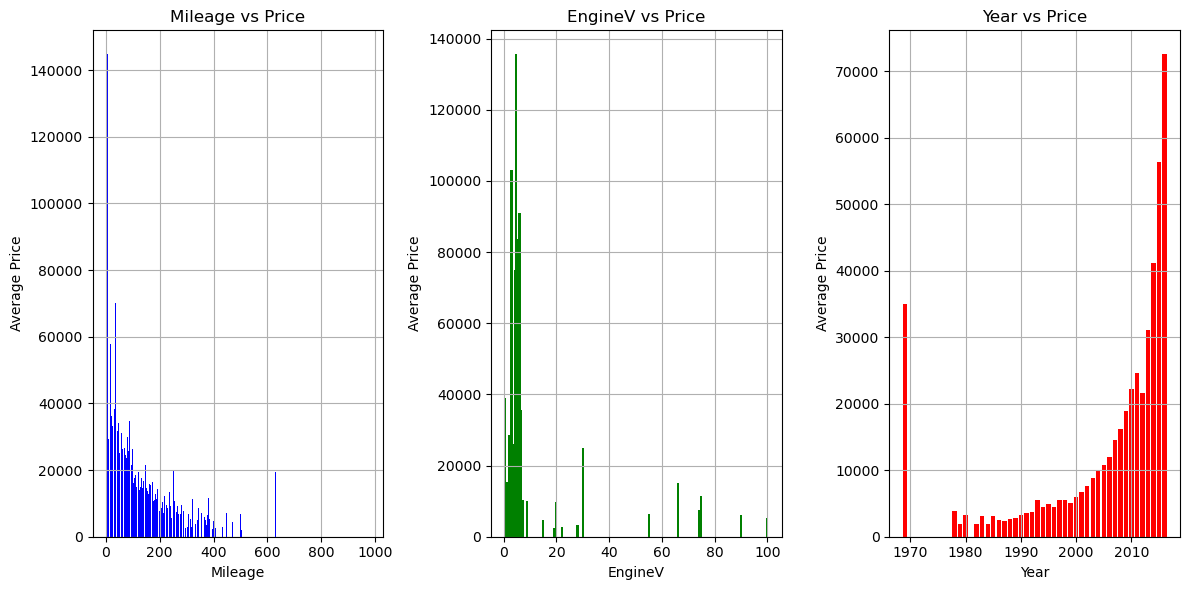

In [72]:
# Calcular el promedio de Price para cada valor único de Mileage, EngineV y Year
avg_price_mileage = df.groupby('Mileage')['Price'].mean()
avg_price_enginev = df.groupby('EngineV')['Price'].mean()
avg_price_year = df.groupby('Year')['Price'].mean()

# Crear el gráfico de barras
plt.figure(figsize=(12, 6))

# Gráfico de barras para Mileage vs Price
plt.subplot(1, 3, 1)
plt.bar(avg_price_mileage.index, avg_price_mileage.values, color='blue')
plt.title('Mileage vs Price')
plt.xlabel('Mileage')
plt.ylabel('Average Price')
plt.grid(True)

# Gráfico de barras para EngineV vs Price
plt.subplot(1, 3, 2)
plt.bar(avg_price_enginev.index, avg_price_enginev.values, color='green')
plt.title('EngineV vs Price')
plt.xlabel('EngineV')
plt.ylabel('Average Price')
plt.grid(True)

# Gráfico de barras para Year vs Price
plt.subplot(1, 3, 3)
plt.bar(avg_price_year.index, avg_price_year.values, color='red')
plt.title('Year vs Price')
plt.xlabel('Year')
plt.ylabel('Average Price')
plt.grid(True)

# Ajustar automáticamente la distribución de los subgráficos
plt.tight_layout()

# Mostrar el gráfico
plt.show()

Rango de _"Years"_

In [29]:
print(f"Desde {df.Year.min()} hasta {df.Year.max()}")

1969

### Preprocesamiento y Feature Engineering

Imputamos Price

In [6]:
# Imputación de valores faltantes con la mediana
median_price = df['Price'].median()
df['Price'].fillna(median_price, inplace=True)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_33020\2820056842.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Price'].fillna(median_price, inplace=True)


Imputamos medina_enginev

In [7]:
# Imputación de valores faltantes con la mediana
median_enginev = df['EngineV'].median()
df['EngineV'].fillna(median_enginev, inplace=True)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_33020\1938038621.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['EngineV'].fillna(median_enginev, inplace=True)



Vamos a descartar la variable Model por simplicidad

In [8]:
df.drop(['Model'], inplace=True, axis=1)

Normalizar

In [9]:
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_features = [col for col in numeric_features if col not in ['Price']]
columns_to_keep = ['Mileage', 'EngineV']
numeric_features_to_scale = [col for col in numeric_features if col in columns_to_keep]

In [10]:
# Estandarizar las columnas numéricas
scaler = StandardScaler()
df[numeric_features_to_scale] = scaler.fit_transform(df[numeric_features_to_scale])

Categoricas: OneHotEncoder

In [11]:
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()

In [12]:
df = pd.get_dummies(df, columns=categorical_features)

### Train y Test

In [13]:
SEED = 12345
TEST_SIZE = 0.2

In [14]:
X = df.drop(columns=['Price'])  # Variables predictoras
y = df['Price']  # Variable objetivo

# División en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=SEED)

In [15]:
# Combinar X_train y y_train en un solo DataFrame
train = pd.concat([X_train, y_train], axis=1)

# Combinar X_test y y_test en un solo DataFrame
test = pd.concat([X_test, y_test], axis=1)

In [16]:
conjuntos = {"X_train": X_train, "X_test": X_test, "y_train": y_train, "y_test": y_test}
for key, value in conjuntos.items():
    print(f"{key}: {len(value)} filas")

X_train: 3476 filas
X_test: 869 filas
y_train: 3476 filas
y_test: 869 filas


### Modelos

In [17]:
from sklearn.metrics import mean_squared_error


### Support Vector Regressor

In [18]:
#Genero una metrica para que lightGBM haga la evaluación y pueda hacer early_stopping en el cross validation
# def svr_custom_metric_accuracy(dy_pred, dy_true):
#     metric_name = 'accuracy'
#     value = accuracy_score(dy_true.get_label(), dy_pred.argmax(axis=1))
#     is_higher_better = True
#     return(metric_name, value, is_higher_better)

#Funcion objetivo a optimizar. En este caso vamos a hacer 5fold cv sobre el conjunto de train. 
# El score de CV es el objetivo a optimizar. Ademas vamos a usar los 5 modelos del CV para estimar el conjunto de test,
# registraremos en optuna las predicciones, matriz de confusion y el score en test.
# CV Score -> Se usa para determinar el rendimiento de los hiperparametros con precision 
# Test Score -> Nos permite testear que esta todo OK, no use (ni debo usar) esos datos para nada en el entrenamiento 
# o la optimizacion de hiperparametros

from sklearn.svm import SVR
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np
import os
from joblib import dump

def cv_es_svr_objective(trial):

    # Parámetros para SVR
    svr_params = {      
        'C': trial.suggest_loguniform('C', 1e-5, 100),
        'kernel': trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid']),
        'degree': trial.suggest_int('degree', 1, 5),
        'gamma': trial.suggest_categorical('gamma', ['scale', 'auto']),
        'epsilon': trial.suggest_loguniform('epsilon', 1e-5, 1.0),
    } 

    # Vamos a acumular las predicciones de los 5 modelos del CV sobre los datos test
    predictions_ensemble = np.zeros(len(y_test))

    # Score del 5 fold CV inicializado en 0
    score_folds = 0

    # Número de splits del CV
    n_splits = 5

    # Objeto para hacer el split de CV (ya no es estratificado porque estamos en regresión)
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    for i, (if_index, oof_index) in enumerate(kf.split(X_train)):
        
        # Dataset in fold (donde entreno)
        X_if, y_if = X_train.iloc[if_index], y_train.iloc[if_index]
        
        # Dataset Out of fold (donde mido la performance del CV)
        X_oof, y_oof = X_train.iloc[oof_index], y_train.iloc[oof_index]

        # Crear el modelo SVR con los parámetros sugeridos
        svr_model = SVR(**svr_params)
        
        # Entrenar el modelo
        svr_model.fit(X_if, y_if)
        
        # Acumular las predicciones para cada uno de los modelos que determino en los folds
        predictions_ensemble += svr_model.predict(X_test)
        
        # Score del fold (registros de dataset train que en este fold quedan out of fold)
        score_folds += mean_squared_error(y_oof, svr_model.predict(X_oof)) / n_splits

    # Promediamos las predicciones de los 5 modelos
    predictions_ensemble /= n_splits

    # Guardo predicción del trial sobre el conjunto de test
    # Genero nombre de archivo
    predicted_filename = os.path.join(PATH_TO_TEMP_FILES, f'test_{trial.study.study_name}_{trial.number}.joblib')
    # Copia del dataset para guardar la predicción
    predicted_df = test.copy()
    # Genero columna pred con predicciones promediadas de los 5 folds
    predicted_df['pred'] = predictions_ensemble
    # Grabo dataframe en temp_artifacts
    dump(predicted_df, predicted_filename)
    # Indico a optuna que asocie el archivo generado al trial
    upload_artifact(trial, predicted_filename, artifact_store)    

    # Para regresión, no necesitamos una matriz de confusión, pero podríamos grabar un scatter plot
    # de predicciones vs valores reales si lo deseas

    # Determino score en conjunto de test y asocio como métrica adicional en optuna
    test_score = mean_squared_error(y_test, predictions_ensemble)
    trial.set_user_attr("test_score", test_score)

    # Devuelvo score del 5fold cv a optuna para que optimice en base a eso
    return score_folds

In [45]:
#Inicio el store de artefactos (archivos) de optuna
artifact_store = FileSystemArtifactStore(base_path=PATH_TO_OPTUNA_ARTIFACTS)

#Genero estudio
study = optuna.create_study(direction='minimize',
                            storage="sqlite:///lgbm.sqlite3",  # Specify the storage URL here.
                            study_name="SupportVectorRegressor",
                            load_if_exists = True)
#Corro la optimizacion
study.optimize(cv_es_svr_objective, n_trials=1000)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_17112\3258433189.py:2: ExperimentalWarning: FileSystemArtifactStore is experimental (supported from v3.3.0). The interface can change in the future.
  artifact_store = FileSystemArtifactStore(base_path=PATH_TO_OPTUNA_ARTIFACTS)
[I 2024-07-15 19:02:32,099] Using an existing study with name 'SupportVectorRegressor' instead of creating a new one.
C:\Users\Usuario\AppData\Local\Temp\ipykernel_17112\4108806803.py:26: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'C': trial.suggest_loguniform('C', 1e-5, 100),
C:\Users\Usuario\AppData\Local\Temp\ipykernel_17112\4108806803.py:30: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'epsilo

### Random Forest

In [19]:
#Genero una metrica para que lightGBM haga la evaluación y pueda hacer early_stopping en el cross validation
# def rfr_custom_metric_accuracy(dy_pred, dy_true):
#     metric_name = 'accuracy'
#     value = accuracy_score(dy_true.get_label(), dy_pred.argmax(axis=1))
#     is_higher_better = True
#     return(metric_name, value, is_higher_better)

#Funcion objetivo a optimizar. En este caso vamos a hacer 5fold cv sobre el conjunto de train. 
# El score de CV es el objetivo a optimizar. Ademas vamos a usar los 5 modelos del CV para estimar el conjunto de test,
# registraremos en optuna las predicciones, matriz de confusion y el score en test.
# CV Score -> Se usa para determinar el rendimiento de los hiperparametros con precision 
# Test Score -> Nos permite testear que esta todo OK, no use (ni debo usar) esos datos para nada en el entrenamiento 
# o la optimizacion de hiperparametros


def cv_es_rfr_objective(trial):

    # Parámetros para rfr
    rfr_params = {      
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000),
        'max_depth': trial.suggest_int('max_depth', 1, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20)
        #'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2']),
        #'criterion': trial.suggest_categorical('criterion', ['absolute_error', 'squared_error'])
    } 

    # Vamos a acumular las predicciones de los 5 modelos del CV sobre los datos test
    predictions_ensemble = np.zeros(len(y_test))

    # Score del 5 fold CV inicializado en 0
    score_folds = 0

    # Número de splits del CV
    n_splits = 5

    # Objeto para hacer el split de CV (ya no es estratificado porque estamos en regresión)
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    for i, (if_index, oof_index) in enumerate(kf.split(X_train)):
        
        # Dataset in fold (donde entreno)
        X_if, y_if = X_train.iloc[if_index], y_train.iloc[if_index]
        
        # Dataset Out of fold (donde mido la performance del CV)
        X_oof, y_oof = X_train.iloc[oof_index], y_train.iloc[oof_index]

        # Crear el modelo rfr con los parámetros sugeridos
        rfr_model = RandomForestRegressor(**rfr_params)
        
        # Entrenar el modelo
        rfr_model.fit(X_if, y_if)
        
        # Acumular las predicciones para cada uno de los modelos que determino en los folds
        predictions_ensemble += rfr_model.predict(X_test)
        
        # Score del fold (registros de dataset train que en este fold quedan out of fold)
        score_folds += mean_squared_error(y_oof, rfr_model.predict(X_oof)) / n_splits

    # Promediamos las predicciones de los 5 modelos
    predictions_ensemble /= n_splits

    # Guardo predicción del trial sobre el conjunto de test
    # Genero nombre de archivo
    predicted_filename = os.path.join(PATH_TO_TEMP_FILES, f'test_{trial.study.study_name}_{trial.number}.joblib')
    # Copia del dataset para guardar la predicción
    predicted_df = test.copy()
    # Genero columna pred con predicciones promediadas de los 5 folds
    predicted_df['pred'] = predictions_ensemble
    # Grabo dataframe en temp_artifacts
    dump(predicted_df, predicted_filename)
    # Indico a optuna que asocie el archivo generado al trial
    upload_artifact(trial, predicted_filename, artifact_store)    

    # Para regresión, no necesitamos una matriz de confusión, pero podríamos grabar un scatter plot
    # de predicciones vs valores reales si lo deseas

    # Determino score en conjunto de test y asocio como métrica adicional en optuna
    test_score = mean_squared_error(y_test, predictions_ensemble)
    trial.set_user_attr("test_score", test_score)

    # Devuelvo score del 5fold cv a optuna para que optimice en base a eso
    return score_folds

In [ ]:
#Inicio el store de artefactos (archivos) de optuna
artifact_store = FileSystemArtifactStore(base_path=PATH_TO_OPTUNA_ARTIFACTS)

#Genero estudio
study = optuna.create_study(direction='minimize',
                            storage="sqlite:///lgbm.sqlite3",  # Specify the storage URL here.
                            study_name="RandomForestRegressor",
                            load_if_exists = True)
#Corro la optimizacion
study.optimize(cv_es_rfr_objective, n_trials=1000)

### Gradient Boosting

In [20]:
#Genero una metrica para que lightGBM haga la evaluación y pueda hacer early_stopping en el cross validation
# def gbr_custom_metric_accuracy(dy_pred, dy_true):
#     metric_name = 'accuracy'
#     value = accuracy_score(dy_true.get_label(), dy_pred.argmax(axis=1))
#     is_higher_better = True
#     return(metric_name, value, is_higher_better)

#Funcion objetivo a optimizar. En este caso vamos a hacer 5fold cv sobre el conjunto de train. 
# El score de CV es el objetivo a optimizar. Ademas vamos a usar los 5 modelos del CV para estimar el conjunto de test,
# registraremos en optuna las predicciones, matriz de confusion y el score en test.
# CV Score -> Se usa para determinar el rendimiento de los hiperparametros con precision 
# Test Score -> Nos permite testear que esta todo OK, no use (ni debo usar) esos datos para nada en el entrenamiento 
# o la optimizacion de hiperparametros


def cv_es_gbr_objective(trial):

    # Parámetros para gbr
    gbr_params = {      
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 1.0),
        'max_depth': trial.suggest_int('max_depth', 1, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        #'loss': trial.suggest_categorical('loss', ['huber', 'quantile'])
    } 

    # Vamos a acumular las predicciones de los 5 modelos del CV sobre los datos test
    predictions_ensemble = np.zeros(len(y_test))

    # Score del 5 fold CV inicializado en 0
    score_folds = 0

    # Número de splits del CV
    n_splits = 5

    # Objeto para hacer el split de CV (ya no es estratificado porque estamos en regresión)
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    for i, (if_index, oof_index) in enumerate(kf.split(X_train)):
        
        # Dataset in fold (donde entreno)
        X_if, y_if = X_train.iloc[if_index], y_train.iloc[if_index]
        
        # Dataset Out of fold (donde mido la performance del CV)
        X_oof, y_oof = X_train.iloc[oof_index], y_train.iloc[oof_index]

        # Crear el modelo gbr con los parámetros sugeridos
        gbr_model = GradientBoostingRegressor(**gbr_params)
        
        # Entrenar el modelo
        gbr_model.fit(X_if, y_if)
        
        # Acumular las predicciones para cada uno de los modelos que determino en los folds
        predictions_ensemble += gbr_model.predict(X_test)
        
        # Score del fold (registros de dataset train que en este fold quedan out of fold)
        score_folds += mean_squared_error(y_oof, gbr_model.predict(X_oof)) / n_splits

    # Promediamos las predicciones de los 5 modelos
    predictions_ensemble /= n_splits

    # Guardo predicción del trial sobre el conjunto de test
    # Genero nombre de archivo
    predicted_filename = os.path.join(PATH_TO_TEMP_FILES, f'test_{trial.study.study_name}_{trial.number}.joblib')
    # Copia del dataset para guardar la predicción
    predicted_df = test.copy()
    # Genero columna pred con predicciones promediadas de los 5 folds
    predicted_df['pred'] = predictions_ensemble
    # Grabo dataframe en temp_artifacts
    dump(predicted_df, predicted_filename)
    # Indico a optuna que asocie el archivo generado al trial
    upload_artifact(trial, predicted_filename, artifact_store)    

    # Para regresión, no necesitamos una matriz de confusión, pero podríamos grabar un scatter plot
    # de predicciones vs valores reales si lo deseas

    # Determino score en conjunto de test y asocio como métrica adicional en optuna
    test_score = mean_squared_error(y_test, predictions_ensemble)
    trial.set_user_attr("test_score", test_score)

    # Devuelvo score del 5fold cv a optuna para que optimice en base a eso
    return score_folds

In [ ]:
#Inicio el store de artefactos (archivos) de optuna
artifact_store = FileSystemArtifactStore(base_path=PATH_TO_OPTUNA_ARTIFACTS)

#Genero estudio
study = optuna.create_study(direction='minimize',
                            storage="sqlite:///lgbm.sqlite3",  # Specify the storage URL here.
                            study_name="GradientBoostingRegressor",
                            load_if_exists = True)
#Corro la optimizacion
study.optimize(cv_es_gbr_objective, n_trials=1000)

### Multilayer Perceptron

In [21]:
#Genero una metrica para que lightGBM haga la evaluación y pueda hacer early_stopping en el cross validation
# def mlpr_custom_metric_accuracy(dy_pred, dy_true):
#     metric_name = 'accuracy'
#     value = accuracy_score(dy_true.get_label(), dy_pred.argmax(axis=1))
#     is_higher_better = True
#     return(metric_name, value, is_higher_better)

#Funcion objetivo a optimizar. En este caso vamos a hacer 5fold cv sobre el conjunto de train. 
# El score de CV es el objetivo a optimizar. Ademas vamos a usar los 5 modelos del CV para estimar el conjunto de test,
# registraremos en optuna las predicciones, matriz de confusion y el score en test.
# CV Score -> Se usa para determinar el rendimiento de los hiperparametros con precision 
# Test Score -> Nos permite testear que esta todo OK, no use (ni debo usar) esos datos para nada en el entrenamiento 
# o la optimizacion de hiperparametros


def cv_es_mlpr_objective(trial):

    # Parámetros para mlpr
    mlpr_params = {      
        'hidden_layer_sizes': trial.suggest_categorical('hidden_layer_sizes', [(50,), (100,), (50, 50), (100, 50)]),
        'activation': trial.suggest_categorical('activation', ['relu', 'tanh', 'logistic']),
        'solver': trial.suggest_categorical('solver', ['adam', 'sgd']),
        'alpha': trial.suggest_loguniform('alpha', 1e-5, 1e-1),
        'learning_rate': trial.suggest_categorical('learning_rate', ['constant', 'invscaling', 'adaptive']),
        'max_iter': trial.suggest_int('max_iter', 100, 1000)
    } 

    # Vamos a acumular las predicciones de los 5 modelos del CV sobre los datos test
    predictions_ensemble = np.zeros(len(y_test))

    # Score del 5 fold CV inicializado en 0
    score_folds = 0

    # Número de splits del CV
    n_splits = 5

    # Objeto para hacer el split de CV (ya no es estratificado porque estamos en regresión)
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    for i, (if_index, oof_index) in enumerate(kf.split(X_train)):
        
        # Dataset in fold (donde entreno)
        X_if, y_if = X_train.iloc[if_index], y_train.iloc[if_index]
        
        # Dataset Out of fold (donde mido la performance del CV)
        X_oof, y_oof = X_train.iloc[oof_index], y_train.iloc[oof_index]

        # Crear el modelo mlpr con los parámetros sugeridos
        mlpr_model = MLPRegressor(**mlpr_params)
        
        # Entrenar el modelo
        mlpr_model.fit(X_if, y_if)
        
        # Acumular las predicciones para cada uno de los modelos que determino en los folds
        predictions_ensemble += mlpr_model.predict(X_test)
        
        # Score del fold (registros de dataset train que en este fold quedan out of fold)
        score_folds += mean_squared_error(y_oof, mlpr_model.predict(X_oof)) / n_splits

    # Promediamos las predicciones de los 5 modelos
    predictions_ensemble /= n_splits

    # Guardo predicción del trial sobre el conjunto de test
    # Genero nombre de archivo
    predicted_filename = os.path.join(PATH_TO_TEMP_FILES, f'test_{trial.study.study_name}_{trial.number}.joblib')
    # Copia del dataset para guardar la predicción
    predicted_df = test.copy()
    # Genero columna pred con predicciones promediadas de los 5 folds
    predicted_df['pred'] = predictions_ensemble
    # Grabo dataframe en temp_artifacts
    dump(predicted_df, predicted_filename)
    # Indico a optuna que asocie el archivo generado al trial
    upload_artifact(trial, predicted_filename, artifact_store)    

    # Para regresión, no necesitamos una matriz de confusión, pero podríamos grabar un scatter plot
    # de predicciones vs valores reales si lo deseas

    # Determino score en conjunto de test y asocio como métrica adicional en optuna
    test_score = mean_squared_error(y_test, predictions_ensemble)
    trial.set_user_attr("test_score", test_score)

    # Devuelvo score del 5fold cv a optuna para que optimice en base a eso
    return score_folds

In [ ]:
#Inicio el store de artefactos (archivos) de optuna
artifact_store = FileSystemArtifactStore(base_path=PATH_TO_OPTUNA_ARTIFACTS)

#Genero estudio
study = optuna.create_study(direction='minimize',
                            storage="sqlite:///lgbm.sqlite3",  # Specify the storage URL here.
                            study_name="MultilayerPerceptronRegressor",
                            load_if_exists = True)
#Corro la optimizacion
study.optimize(cv_es_mlpr_objective, n_trials=1000)

In [22]:
study_rfr = optuna.create_study(direction='minimize',
                            storage="sqlite:///lgbm.sqlite3",  # Specify the storage URL here.
                            study_name="RandomForestRegressor",
                            load_if_exists = True)


rfr_dataset = load(os.path.join(PATH_TO_OPTUNA_ARTIFACTS,get_artifact_filename(study_rfr,'test')))

[I 2024-07-15 19:24:28,979] Using an existing study with name 'RandomForestRegressor' instead of creating a new one.


In [29]:
rfr_dataset['pred'] = [float(r) for r in rfr_dataset['pred']]

mean_squared_error(y_test, rfr_dataset['pred'])
r2 = r2_score(y_test, rfr_dataset['pred'])
mae = mean_absolute_error(y_test, rfr_dataset['pred'])


In [30]:
r2

0.564522911069649

In [31]:
mae

6656.624841454313

Modelos a utilizar

In [158]:
regression_models = {
    'SVM': SVR(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'MLP': MLPRegressor()
}

Hiperparámetros de los modelos

In [159]:
regression_param_grids = {
    'SVM': {
        'model__C': [0.1, 1, 10], 
        'model__kernel': ['rbf', 'linear']
    },
    'Random Forest': {
        'model__n_estimators': [50, 100], 
        'model__max_depth': [None, 10, 20]
    },
    'Gradient Boosting': {
        'model__n_estimators': [50, 100], 
        'model__learning_rate': [0.01, 0.1]
    },
    'MLP': {
        'model__hidden_layer_sizes': [(50,), (100,)], 
        'model__alpha': [0.0001, 0.001]
    }
}


Función para entrenar los modelos

In [160]:
# Función para evaluar y comparar modelos
def train_models(X, y, models, param_grids, cv=5, scoring='neg_mean_squared_error'):
    results = []
    for name, model in models.items():
        pipeline = Pipeline(steps=[("model", model)])
        grid_search = GridSearchCV(pipeline, param_grids[name], cv=cv, scoring=scoring, n_jobs=-1)
        grid_search.fit(X, y)
        results.append({
            'Model': name,
            'Best Score': grid_search.best_score_,
            'Best Params': grid_search.best_params_
        })
       
        # Guardamos los resultados
        results_df = pd.DataFrame(results)
        results_df.to_csv(f'./metrics/{name}_regressor.csv', index=False, sep=';')
       
        # Guardar el mejor modelo
        pkl_Filename = f"./models/{name}_regressor.pkl"  
        with open(pkl_Filename, 'wb') as file:
            pickle.dump(grid_search.best_estimator_, file)
    
    return pd.DataFrame(results)

Entrenamos los modelos

In [161]:
# Evaluar modelos de clasificación
print("Resultados de Clasificación:")
results = train_models(X_train, y_train, regression_models, regression_param_grids)
print(results)

Resultados de Clasificación:
               Model    Best Score  \
0                SVM -5.091542e+08   
1      Random Forest -2.487160e+08   
2  Gradient Boosting -2.435451e+08   
3                MLP -6.088346e+08   

                                         Best Params  
0        {'model__C': 10, 'model__kernel': 'linear'}  
1  {'model__max_depth': 10, 'model__n_estimators'...  
2  {'model__learning_rate': 0.1, 'model__n_estima...  
3  {'model__alpha': 0.0001, 'model__hidden_layer_...  


c:\Users\Usuario\.conda\envs\ldi2\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Levantamos los modelos guardados

In [162]:
SVM = pickle_load('SVM_regressor')
RandomForest = pickle_load('Random Forest_regressor')
GradientBoosting = pickle_load('Gradient Boosting_regressor')
MLP = pickle_load('SVM_regressor')

Función para realizar predicciones

In [163]:
def test_model(X_test):
    predictions_df = pd.DataFrame()
    predictions_df['SVM'] = SVM.predict(X_test) 
    predictions_df['RandomForest'] = RandomForest.predict(X_test)
    predictions_df['GradientBoosting'] = GradientBoosting.predict(X_test)
    predictions_df['MLP'] = MLP.predict(X_test)
    
    return predictions_df

Predicciones

In [164]:
predicciones = test_model(X_test)

##### Métricas del SVR

MSE, R2 y MAE

In [168]:
mse = mean_squared_error(y_test, predicciones['SVM'])
r2 = r2_score(y_test, predicciones['SVM'])
mae = mean_absolute_error(y_test, predicciones['SVM'])

print(f'MSE: {mse}')
print(f'R2: {r2}')
print(f'MAE: {mae}')

MSE: 581939752.3754058
R2: 0.17236266780123954
MAE: 9566.30359672128


Importancia de variables

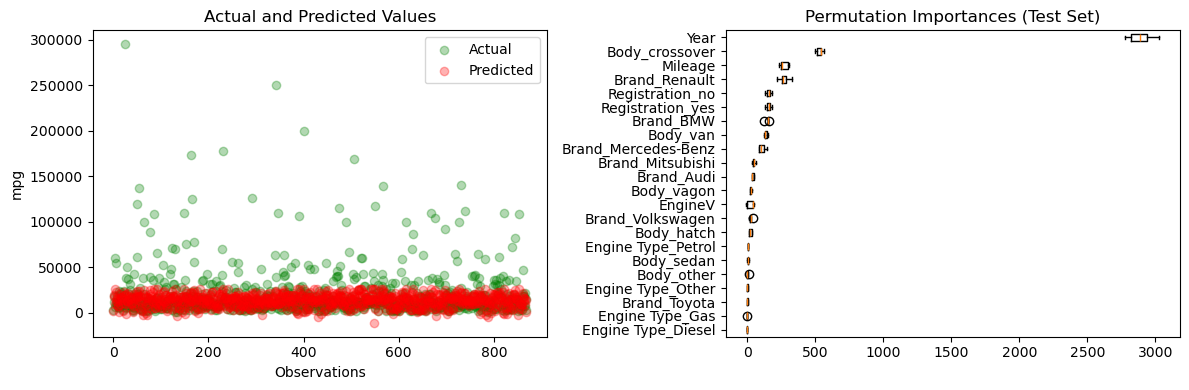

In [172]:
# Crear la figura y los subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Grafico 1: Actual and predicted values
axs[0].scatter(x=range(0, y_test.size), y=y_test, c='green', label='Actual', alpha=0.3)
axs[0].scatter(x=range(0, predicciones['SVM'].size), y=predicciones['SVM'], c='red', label='Predicted', alpha=0.3)
axs[0].set_title('Actual and Predicted Values')
axs[0].set_xlabel('Observations')
axs[0].set_ylabel('mpg')
axs[0].legend()

# Grafico 2: Permutation Importances
imps = permutation_importance(SVM, X_test, y_test,
                              n_repeats=5,
                              scoring="neg_mean_absolute_error",
                              n_jobs=-1, random_state=42)
perm_sorted_idx = imps.importances_mean.argsort()
axs[1].boxplot(imps.importances[perm_sorted_idx].T, vert=False,
               labels=X_test.columns[perm_sorted_idx])
axs[1].set_title("Permutation Importances (Test Set)")

# Ajustar el layout para evitar solapamiento
plt.tight_layout()

# Mostrar la figura
plt.show()


##### Métricas del Random Forest

MSE, R2 y MAE

In [174]:
mse = mean_squared_error(y_test, predicciones['RandomForest'])
r2 = r2_score(y_test, predicciones['RandomForest'])
mae = mean_absolute_error(y_test, predicciones['RandomForest'])

print(f'MSE: {mse}')
print(f'R2: {r2}')
print(f'MAE: {mae}')

MSE: 243296111.25137776
R2: 0.6539831767317961
MAE: 5843.398291809399


Importancia de variables

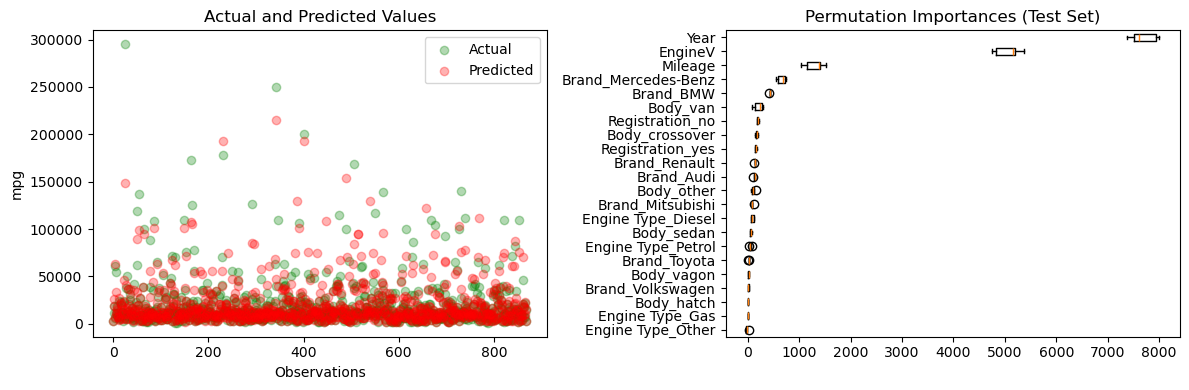

In [175]:
# Crear la figura y los subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Grafico 1: Actual and predicted values
axs[0].scatter(x=range(0, y_test.size), y=y_test, c='green', label='Actual', alpha=0.3)
axs[0].scatter(x=range(0, predicciones['RandomForest'].size), y=predicciones['RandomForest'], c='red', label='Predicted', alpha=0.3)
axs[0].set_title('Actual and Predicted Values')
axs[0].set_xlabel('Observations')
axs[0].set_ylabel('mpg')
axs[0].legend()

# Grafico 2: Permutation Importances
imps = permutation_importance(RandomForest, X_test, y_test,
                              n_repeats=5,
                              scoring="neg_mean_absolute_error",
                              n_jobs=-1, random_state=42)
perm_sorted_idx = imps.importances_mean.argsort()
axs[1].boxplot(imps.importances[perm_sorted_idx].T, vert=False,
               labels=X_test.columns[perm_sorted_idx])
axs[1].set_title("Permutation Importances (Test Set)")

# Ajustar el layout para evitar solapamiento
plt.tight_layout()

# Mostrar la figura
plt.show()


##### Métricas del Gradient Boosting

MSE, R2 y MAE

In [176]:
mse = mean_squared_error(y_test, predicciones['GradientBoosting'])
r2 = r2_score(y_test, predicciones['GradientBoosting'])
mae = mean_absolute_error(y_test, predicciones['GradientBoosting'])

print(f'MSE: {mse}')
print(f'R2: {r2}')
print(f'MAE: {mae}')

MSE: 265781989.1702324
R2: 0.622003660060279
MAE: 6530.583613323248


Importancia de variables

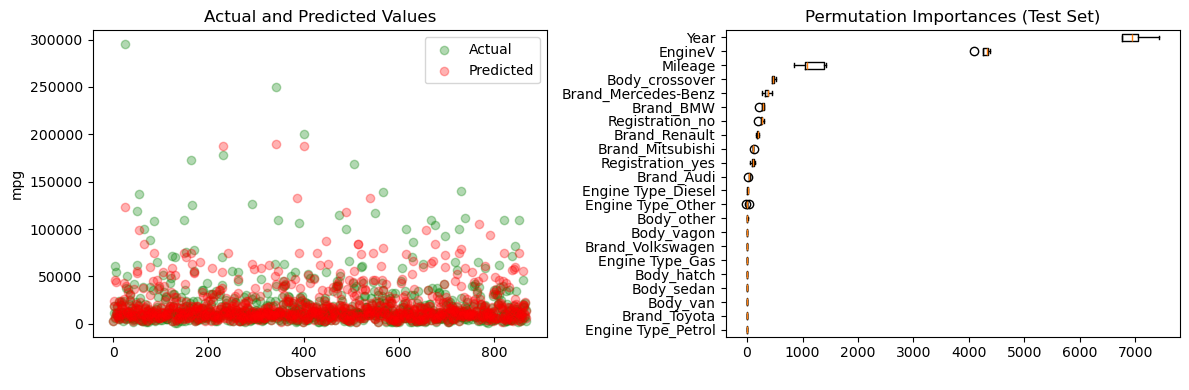

In [177]:
# Crear la figura y los subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Grafico 1: Actual and predicted values
axs[0].scatter(x=range(0, y_test.size), y=y_test, c='green', label='Actual', alpha=0.3)
axs[0].scatter(x=range(0, predicciones['GradientBoosting'].size), y=predicciones['GradientBoosting'], c='red', label='Predicted', alpha=0.3)
axs[0].set_title('Actual and Predicted Values')
axs[0].set_xlabel('Observations')
axs[0].set_ylabel('mpg')
axs[0].legend()

# Grafico 2: Permutation Importances
imps = permutation_importance(GradientBoosting, X_test, y_test,
                              n_repeats=5,
                              scoring="neg_mean_absolute_error",
                              n_jobs=-1, random_state=42)
perm_sorted_idx = imps.importances_mean.argsort()
axs[1].boxplot(imps.importances[perm_sorted_idx].T, vert=False,
               labels=X_test.columns[perm_sorted_idx])
axs[1].set_title("Permutation Importances (Test Set)")

# Ajustar el layout para evitar solapamiento
plt.tight_layout()

# Mostrar la figura
plt.show()


##### Métricas del MLP

MSE, R2 y MAE

In [178]:
mse = mean_squared_error(y_test, predicciones['MLP'])
r2 = r2_score(y_test, predicciones['MLP'])
mae = mean_absolute_error(y_test, predicciones['MLP'])

print(f'MSE: {mse}')
print(f'R2: {r2}')
print(f'MAE: {mae}')

MSE: 581939752.3754058
R2: 0.17236266780123954
MAE: 9566.30359672128


Importancia de variables

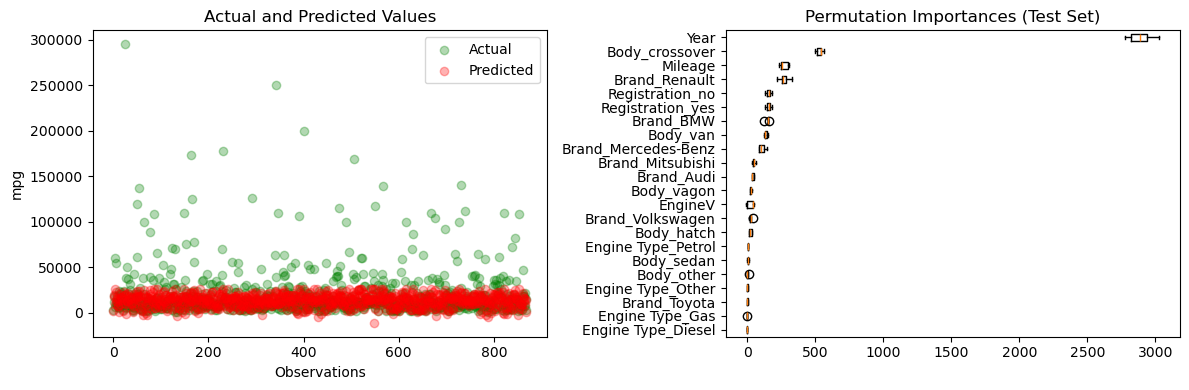

In [179]:
# Crear la figura y los subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Grafico 1: Actual and predicted values
axs[0].scatter(x=range(0, y_test.size), y=y_test, c='green', label='Actual', alpha=0.3)
axs[0].scatter(x=range(0, predicciones['MLP'].size), y=predicciones['MLP'], c='red', label='Predicted', alpha=0.3)
axs[0].set_title('Actual and Predicted Values')
axs[0].set_xlabel('Observations')
axs[0].set_ylabel('mpg')
axs[0].legend()

# Grafico 2: Permutation Importances
imps = permutation_importance(MLP, X_test, y_test,
                              n_repeats=5,
                              scoring="neg_mean_absolute_error",
                              n_jobs=-1, random_state=42)
perm_sorted_idx = imps.importances_mean.argsort()
axs[1].boxplot(imps.importances[perm_sorted_idx].T, vert=False,
               labels=X_test.columns[perm_sorted_idx])
axs[1].set_title("Permutation Importances (Test Set)")

# Ajustar el layout para evitar solapamiento
plt.tight_layout()

# Mostrar la figura
plt.show()
